In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

DATA_DIR = "/home/tuandinh/Desktop/Computer_Vision_Task/data_1"
DATA_DIR_CAT = os.path.join(DATA_DIR,"cat")
DATA_DIR_KANGAROO = os.path.join(DATA_DIR, 'kangaroo')

list = os.listdir(DATA_DIR_CAT)
list[1].split(".")[1]
os.listdir(DATA_DIR_KANGAROO)


In [31]:
def remove_unusefull_image(DIR):
    # remove item is not image in DIR
    for item in os.listdir(DIR):
        type_img = item.split(".")[1]
        if type_img not in ["jpg","png","jpeg"]:
            os.remove(os.path.join(DIR, item))
            print(f"Remove image {item}")
    print("All done")

# I want to name of image is beautifull, therefore I change the name of image in this function
def change_name_of_image(DIR):
    count = 0
    for item in os.listdir(DIR):
        os.rename(os.path.join(DIR,item), os.path.join(DIR,str(count)+ '.' + item.split(".")[1]))
        count+=1
        if count%50==0:
            print("Replaced name of 50 images")
    print("All done")

In [ ]:
remove_unusefull_image(DATA_DIR_CAT)
remove_unusefull_image(DATA_DIR_KANGAROO)

In [34]:
change_name_of_image(DATA_DIR_CAT)
change_name_of_image(DATA_DIR_KANGAROO)
# End then we have result that naem of image such as "1.jpg, 2.jpg and so on"

Replaced name of 50 images
Replaced name of 50 images
All done
Replaced name of 50 images
Replaced name of 50 images
All done


# Prepare for traning
  + I use tensorflow to prepare data for traning task
  + Define some parameters for the loader

In [35]:
img_size = (224,224)
batch_size = 16

In [36]:
train_ds = tf.keras.utils.image_dataset_from_directory(
            DATA_DIR,
            validation_split=0.2,
            subset="training",
            seed=42,
            image_size=img_size,
            batch_size=batch_size)

Found 194 files belonging to 2 classes.
Using 156 files for training.


2022-12-18 03:18:48.118969: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-18 03:18:48.119030: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ngoctuan): /proc/driver/nvidia/version does not exist
2022-12-18 03:18:48.121904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
class_name = train_ds.class_names
class_name

['cat', 'kangaroo']

# Visualize data

In [2]:
# def plot(image_batch, label_batch):
#     plt.figure(figsize=(10,5))
#     for i in range(10):
#         ax = plt.subplot(2,5,i+1)
#         img = cv2.imread(str(image_batch[i]))
#         img = cv2.resize(img,(224,224))
#         plt.imshow(img)
#         plt.title(label_batch[i])
#         plt.axis("off")

In [7]:
os.listdir(DATA_DIR_CAT)[1]

'84.jpg'

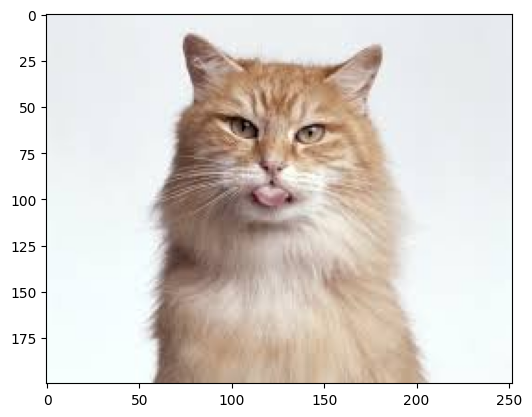

In [14]:
img_path = os.path.join(DATA_DIR_CAT,os.listdir(DATA_DIR_CAT)[1])
img_cat = cv2.imread(img_path)
img_cat = cv2.cvtColor(img_cat, cv2.COLOR_RGB2BGR)
plt.imshow(img_cat)

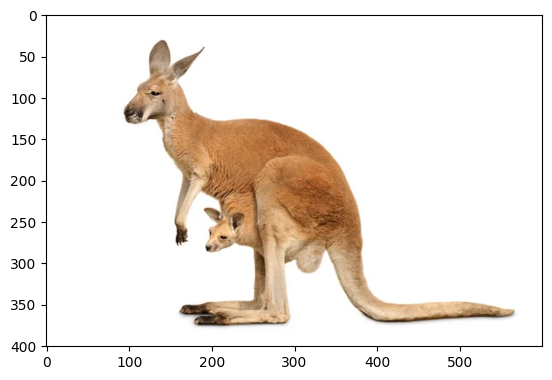

In [21]:
img_path = os.path.join(DATA_DIR_KANGAROO,os.listdir(DATA_DIR_KANGAROO)[1])
img_kangaroo = cv2.imread(img_path)
img_kangaroo = cv2.cvtColor(img_kangaroo, cv2.COLOR_RGB2BGR)
plt.imshow(img_kangaroo)

# **Creat Model for traning**
## Create a generic VGG block

In [22]:
class Block(tf.keras.Model):
    def __init__(self, filters, kernel_size, repetitions, pool_size=2, strides=2):
        super(Block,self).__init__()
        self.filter = filters
        self.kernel_size = kernel_size
        self.repetitions = repetitions
        # Define a conv2D_0, conv2D_1, etc based on the number of repetitions
        for i in range(4):
            # Define a Conv2D layer, specifying filters, kernel_size, activation and padding.
            vars(self)[f'conv2D_{i}'] = tf.keras.layers.Conv2D(filters,kernel_size,activation='relu', padding='same')
        # Define the max pool layer that will be added after the Conv2D blocks
        self.max_pool = tf.keras.layers.MaxPool2D(pool_size, strides)

    def call(self, inputs):
        # access the class's conv2D_0 layer
        conv2D_0 = vars(self)[f'conv2D_{0}']
        # Connect the conv2D_0 layer to inputs
        x = conv2D_0(inputs=inputs)

        # for the remaining conv2D_i layers from 1 to `repetitions` they will be connected to the previous layer
        for i in range(1,3):
            # access conv2D_i by formatting the integer `i`. (hint: check how these were saved using `vars()` earlier)
            conv2D_i = vars(self)[f'conv2D_{i}']
            
            # Use the conv2D_i and connect it to the previous layer
            x = conv2D_i(x)

        # Finally, add the max_pool layer
        max_pool = self.max_pool(x)
        return max_pool